In [151]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
#importing library
from collections import Counter
from music21 import converter, instrument, note, chord, stream
from keras.layers import Input, Dense, Reshape, Dropout, Bidirectional, LSTM
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
from music21.midi import percussion
from music21 import pitch
import pretty_midi

In [155]:
def get_notes():
    """ Get all the notes and chords from the midi files """
    notes = []

    for file in glob.glob("midi_songs/*.mid"):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
        #pm = percussion.PercussionMapper()     
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                midiNumber = element.pitch.midi
                notes.append(str(midiNumber))
                #if midiNumber>=35 and midiNumber<=81:
                #    try:
                        #bassDrum1Pitch = pitch.Pitch(midiNumber)
                        #mapping = pm.midiPitchToInstrument(bassDrum1Pitch)
                        #print (bassDrum1Pitch, mapping)
                        #notes.append(str(midiNumber))
                        #notes.append(bassDrum1Pitch)
                    #except:
                    #    pass
            #elif isinstance(element, chord.Chord):
            #    notes.append('.'.join(str(n) for n in element.normalOrder))

    return notes



In [156]:
notes = get_notes()
n_vocab = len(set(notes))
print (set(notes))

Parsing midi_songs/73_neworleans-funk_93_fill_4-4.mid
Parsing midi_songs/3_rock_60_fill_4-4.mid
Parsing midi_songs/116_rock_95_fill_4-4.mid
Parsing midi_songs/135_soul_105_fill_4-4.mid
Parsing midi_songs/26_hiphop_67_fill_4-4.mid
Parsing midi_songs/87_neworleans-funk_93_fill_4-4.mid
Parsing midi_songs/110_rock_95_fill_4-4.mid
Parsing midi_songs/79_neworleans-funk_93_fill_4-4.mid
Parsing midi_songs/90_neworleans-funk_93_fill_4-4.mid
Parsing midi_songs/22_pop-soft_83_beat_4-4.mid
Parsing midi_songs/133_soul_105_beat_4-4.mid
Parsing midi_songs/149_soul_105_fill_4-4.mid
Parsing midi_songs/2_rock_60_fill_4-4.mid
Parsing midi_songs/36_hiphop_67_fill_4-4.mid
Parsing midi_songs/55_funk_112_fill_4-4.mid
Parsing midi_songs/137_soul_105_fill_4-4.mid
Parsing midi_songs/125_rock_93_fill_4-4.mid
Parsing midi_songs/77_neworleans-funk_93_fill_4-4.mid
Parsing midi_songs/19_pop-soft_83_fill_4-4.mid
Parsing midi_songs/102_hiphop_70_fill_4-4.mid
Parsing midi_songs/15_pop-soft_83_fill_4-4.mid
Parsing midi_

In [157]:
def prepare_sequences(notes, sequence_length):
    print("\n**Preparing sequences for training**")
    pitchnames = sorted(set(i for i in notes)) # list of unique chords and notes
    n_vocab = len(pitchnames)
    print("Pitchnames (unique notes/chords from 'notes') at length {}: {}".format(len(pitchnames),pitchnames))
    # enumerate pitchnames into dictionary embedding
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    print("Note to integer embedding created at length {}".format(len(note_to_int)))

    network_input = []
    network_output = []

    # i equals total notes less declared sequence length of LSTM (ie 5000 - 100)
    # sequence input for each i is list of notes i to end of sequence length (ie 0-100 for i = 0)
    # sequence output for each i is single note at i + sequence length (ie 100 for i = 0)
    for i in range(0, len(notes) - sequence_length,1):
        sequence_in = notes[i:i + sequence_length] # 100
        sequence_out = notes[i + sequence_length] # 1

        # enumerate notes and chord sequences with note_to_int enumerated encoding
        # network input/output is a list of encoded notes and chords based on note_to_int encoding
        # if 100 unique notes/chords, the encoding will be between 0-100
        input_add = [note_to_int[char] for char in sequence_in]
        network_input.append(input_add) # sequence length
        output_add = note_to_int[sequence_out]
        network_output.append(output_add) # single note

    print("Network input and output created with (pre-transform) lengths {} and {}".format(len(network_input),len(network_output)))
    # print("Network input and output first list items: {} and {}".format(network_input[0],network_output[0]))
    # print("Network input list item length: {}".format(len(network_input[0])))
    n_patterns = len(network_input) # notes less sequence length
    print("Lengths. N Vocab: {} N Patterns: {} Pitchnames: {}".format(n_vocab,n_patterns, len(pitchnames)))
    print("\n**Reshaping for training**")

    # convert network input/output from lists to numpy arrays
    # reshape input to (notes less sequence length, sequence length)
    # reshape output to (notes less sequence length, unique notes/chords)
    network_input_r = np.reshape(network_input, (n_patterns, sequence_length, 1))
    network_output_r = np_utils.to_categorical(network_output)

    print("Reshaping network input to (notes - sequence length, sequence length) {}".format(network_input_r.shape))
    print("Reshaping network output to (notes - sequence length, unique notes) {}".format(network_output_r.shape))
    return network_input_r, network_output_r, n_patterns, n_vocab, pitchnames


In [158]:

network_input, network_output, n_patterns, n_vocab, pitchnames = prepare_sequences(notes, n_vocab)
#print (network_input, network_output)


**Preparing sequences for training**
Pitchnames (unique notes/chords from 'notes') at length 20: ['22', '26', '36', '37', '38', '40', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '53', '55', '58', '59']
Note to integer embedding created at length 20
Network input and output created with (pre-transform) lengths 9047 and 9047
Lengths. N Vocab: 20 N Patterns: 9047 Pitchnames: 20

**Reshaping for training**
Reshaping network input to (notes - sequence length, sequence length) (9047, 20, 1)
Reshaping network output to (notes - sequence length, unique notes) (9047, 20)


{'48': 258, '50': 136, '45': 119, '47': 137, '43': 346, '58': 46, '38': 3308, '40': 535, '42': 1846, '22': 622, '36': 491, '37': 60, '44': 205, '51': 332, '26': 239, '55': 32, '46': 221, '53': 118, '59': 10, '49': 6}


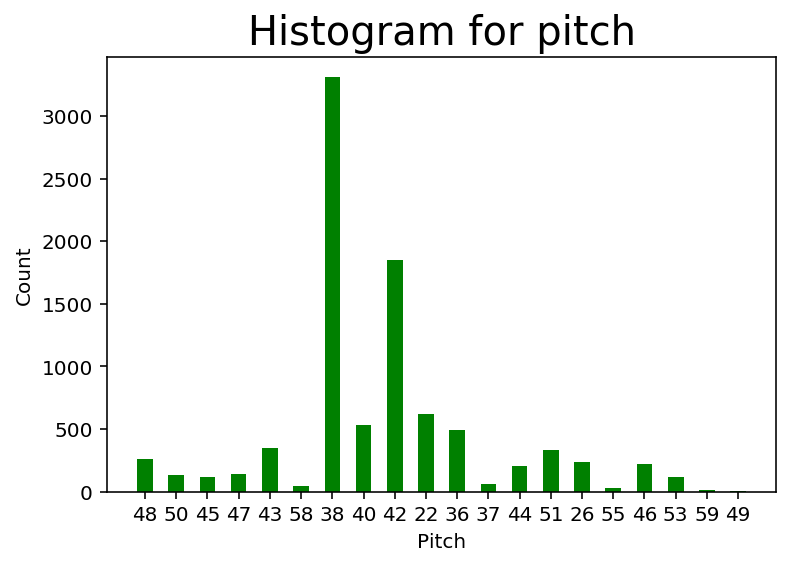

In [159]:
freq = dict(Counter(notes))
print (freq)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#set figure
f, ax = plt.subplots(1,1)

#plt.figure(figsize=(15,5))
plt.bar(freq.keys(), freq.values(), width=.5, color='g')
#set title & axis titles
ax.set_title('Histogram for pitch', fontsize=20)
ax.set_xlabel('Pitch')
ax.set_ylabel('Count')
plt.show()

In [172]:
class GAN():
    def __init__(self, rows):
        self.seq_length = rows
        self.seq_shape = (self.seq_length, 1)
        self.latent_dim = 20
        self.disc_loss = []
        self.gen_loss =[]
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates note sequences
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated_seq)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_discriminator(self):

        model = Sequential()
        model.add(LSTM(512, input_shape=self.seq_shape, return_sequences=True))
        model.add(Bidirectional(LSTM(512)))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        seq = Input(shape=self.seq_shape)
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):

        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.seq_shape), activation='sigmoid'))
        model.add(Reshape(self.seq_shape))
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)

    def train(self, notes, epochs, batch_size=128, sample_interval=50):

        # Load and convert the data
        #notes = get_notes()
        n_vocab = len(set(notes))
        X_train, y_train, n_patterns, n_vocab, pitchnames = prepare_sequences(notes, n_vocab)
        #print (X_train, y_train)
        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Training the model
        for epoch in range(epochs):

            # Training the discriminator
            # Select a random batch of note sequences
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]

            #noise = np.random.choice(range(484), (batch_size, self.latent_dim))
            #noise = (noise-242)/242
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new note sequences
            gen_seqs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            #  Training the Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(noise, real)

            # Print the progress and save into loss lists
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.disc_loss.append(d_loss[0])
                self.gen_loss.append(g_loss)
        #self.generate(notes)
        self.plot_loss()
        
    def plot_loss(self):
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()

In [173]:
gan = GAN(rows=20)    
gan.train(epochs=16, notes=notes, batch_size=2, sample_interval=1)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 20, 512)           1052672   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 1024)              4198400   
_________________________________________________________________
dense_85 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 1)               

/home/bikash/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.706374, acc.: 50.00%] [G loss: 0.659271]
[ 143 1442]


/home/bikash/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.584680, acc.: 50.00%] [G loss: 0.626005]
[6453 5704]
2 [D loss: 0.481686, acc.: 50.00%] [G loss: 0.598538]
[4750 7621]
3 [D loss: 0.496721, acc.: 50.00%] [G loss: 0.582361]
[1582 5718]
4 [D loss: 0.426218, acc.: 50.00%] [G loss: 0.600706]
[3631 5668]
5 [D loss: 0.399263, acc.: 50.00%] [G loss: 0.634164]
[6102 1444]
6 [D loss: 0.420023, acc.: 50.00%] [G loss: 0.640678]
[3339 3882]
7 [D loss: 0.383937, acc.: 50.00%] [G loss: 0.663350]
[1667 3021]
8 [D loss: 0.367811, acc.: 50.00%] [G loss: 0.687250]
[3681 1475]
9 [D loss: 0.392697, acc.: 50.00%] [G loss: 0.685238]
[6940 8843]
10 [D loss: 0.384603, acc.: 50.00%] [G loss: 0.694685]
[5578 2907]
11 [D loss: 0.333947, acc.: 100.00%] [G loss: 0.749585]
[4974 2883]
12 [D loss: 0.311725, acc.: 100.00%] [G loss: 0.838350]
[4280  545]
13 [D loss: 0.272541, acc.: 100.00%] [G loss: 1.053716]
[3388 3838]
14 [D loss: 0.235349, acc.: 100.00%] [G loss: 1.321934]
[3924  180]
15 [D loss: 0.113261, acc.: 100.00%] [G loss: 3.227103]


Generating music based on GAN network

In [178]:
def generate(gan, input_notes):
        # Get pitch names and store in a dictionary
        notes = input_notes
        
        pitchnames = sorted(set(item for item in notes))
        int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
        #print (int_to_note)
        # Use random noise to generate sequences
        noise = np.random.normal(0, 1, (1, gan.latent_dim))

        predictions = gan.generator.predict(noise)
        pred_notes = [x*47+47 for x in predictions[0]]
        notess = []
        for x in pred_notes:
            #if x >=35 and x <=81:
            notess.append(int(x))
        #pred_notes = [int_to_note[int(x)] for x in notess]
        return notess

In [179]:
predictions = generate(gan,notes)
predictions

[64,
 70,
 51,
 59,
 70,
 57,
 49,
 53,
 50,
 58,
 56,
 53,
 80,
 69,
 57,
 52,
 83,
 55,
 66,
 78]

In [180]:
def create_midi(notes):
    new_midi_data = pretty_midi.PrettyMIDI()
    #drum_program = pretty_midi.instrument_name_to_program('SteelDrums')
    drum = pretty_midi.Instrument(program=0, is_drum=True, name="Midi Drums" )
    time = 0
    step = 0.1
    for note_number in notes:
        myNote = pretty_midi.Note(velocity=90, pitch=int(note_number), start=time, end=time+step)
        drum.notes.append(myNote)
        time += step
    new_midi_data.instruments.append(drum)
    return new_midi_data

new_midi_data = create_midi(predictions)
new_midi_data.write('final.mid')